# Pipline Detector

In [117]:
import cv2 
import math
import numpy as np
import matplotlib.pyplot as plt
import json
from skimage.util import img_as_ubyte

# Image Alignment

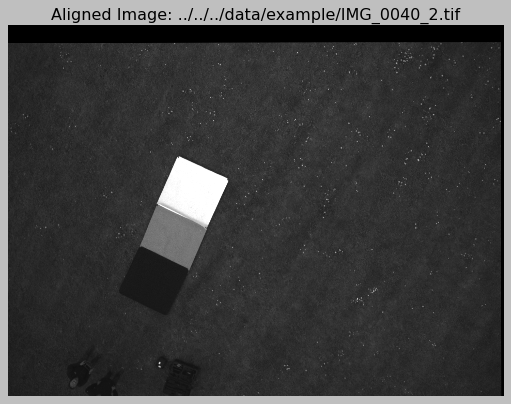

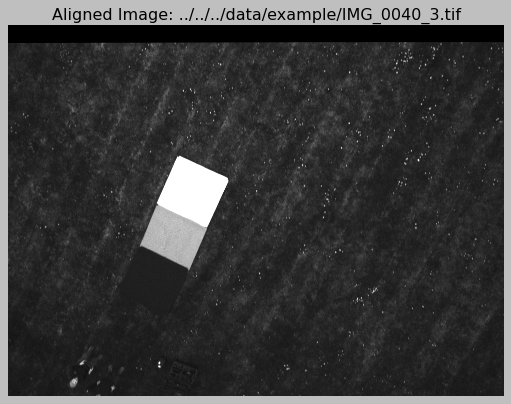

Not enough matches found for ../../../data/example/IMG_0040_4.tif. Skipping alignment.


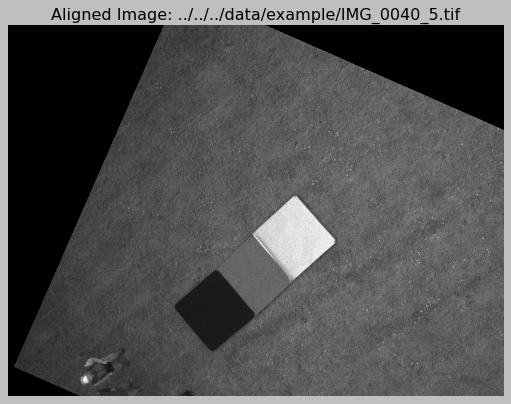

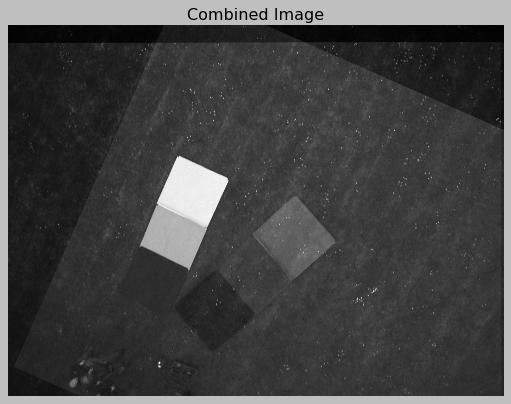

In [135]:
# Paths to your images
image_paths = [
    "data/example/IMG_0040_1.tif",
    "data/example/IMG_0040_2.tif",
    "data/example/IMG_0040_3.tif",
    "data/example/IMG_0040_4.tif",
    "data/example/IMG_0040_5.tif",
]

# Prepend base directory to each image path
image_paths = ["../../../" + path for path in image_paths]

# Function to normalize and equalize image intensity
def normalize_and_equalize_image(image):
    normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    equalized = cv2.equalizeHist(normalized)
    return equalized

# Load and process the reference image (the first one)
reference_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
reference_image_processed = normalize_and_equalize_image(reference_image)

# Initialize SIFT detector 
sift = cv2.SIFT_create(nfeatures=5000)

# Detect and compute descriptors for the reference image
keypoints_ref, descriptors_ref = sift.detectAndCompute(reference_image_processed, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

# Create FLANN based matcher object
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Function to align an image to the reference image
def align_image(image_path, keypoints_ref, descriptors_ref):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Normalize and equalize the image intensity
    image_processed = normalize_and_equalize_image(image)

    # Detect and compute descriptors for the image
    keypoints, descriptors = sift.detectAndCompute(image_processed, None)

    # Match descriptors
    matches = flann.knnMatch(descriptors, descriptors_ref, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Adjusted ratio test threshold
            good_matches.append(m)

    # Ensure we have enough good matches
    if len(good_matches) < 4:  # Minimum number of matches required for estimateAffinePartial2D
        print(f"Not enough matches found for {image_path}. Skipping alignment.")
        return None

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints[match.queryIdx].pt
        points2[i, :] = keypoints_ref[match.trainIdx].pt

    # Find Euclidean transformation
    h, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC, ransacReprojThreshold=5.0)

    # Use the transformation to transform the image
    height, width = reference_image.shape
    aligned_image = cv2.warpAffine(image, h, (width, height))

    return aligned_image

# Align all images to the reference image
aligned_images = [reference_image]
for image_path in image_paths[1:]:
    aligned_image = align_image(image_path, keypoints_ref, descriptors_ref)
    if aligned_image is not None:
        aligned_images.append(aligned_image)

        # Display each aligned image
        plt.figure()
        plt.imshow(aligned_image, cmap='gray')
        plt.title(f'Aligned Image: {image_path}')
        plt.axis('off')
        plt.show()

# Combine aligned images (e.g., taking the mean of aligned images)
combined_image = np.mean(np.array(aligned_images), axis=0).astype(np.uint8)

# Save the combined image
output_path = base_dir + 'data/example/combined_image.tif'
cv2.imwrite(output_path, combined_image)

# Display the combined image
plt.figure()
plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.axis('off')
plt.show()


## Panel Detector

In [119]:
def calculate_panel_size_in_pixels(altitude, pixel_size, resolution, sensor_size_mm, focal_length_m, physical_panel_size):
    """
    Calculate the expected size of an object in pixels based on camera parameters and object physical size.
    
    Parameters:
        altitude (float): Altitude in meters.
        pixel_size (float): Pixel size in meters.
        resolution (tuple): Image resolution (width, height) in pixels.
        sensor_size_mm (float): Sensor diagonal in millimeters.
        focal_length_m (float): Focal length in meters.
        physical_panel_size (tuple): Physical size of the object in meters (width, height).
    
    Returns:
        tuple: Expected width and height of the object in pixels.
    """
    # Convert sensor size to meters
    sensor_size = sensor_size_mm / 1000  # Convert mm to m

    # Calculate sensor width and height based on the aspect ratio and diagonal
    sensor_width = sensor_size * (resolution[0] / math.sqrt(resolution[0]**2 + resolution[1]**2))
    sensor_height = sensor_size * (resolution[1] / math.sqrt(resolution[0]**2 + resolution[1]**2))

    # Calculate horizontal and vertical Field of View (FoV)
    fov_horizontal = 2 * math.atan((sensor_width / 2) / focal_length_m)
    fov_vertical = 2 * math.atan((sensor_height / 2) / focal_length_m)

    # Calculate scale in pixels per meter
    scale_pixels_per_meter = resolution[1] / (altitude * math.tan(fov_vertical / 2))

    # Calculate expected panel size in pixels
    panel_width_pixels = physical_panel_size[0] * scale_pixels_per_meter
    panel_height_pixels = physical_panel_size[1] * scale_pixels_per_meter

    return (panel_width_pixels, panel_height_pixels)

In [120]:
def filter_by_variance(image, blur_kernel_size=15):
    """
    Apply a variance filter to an image to enhance features.
    
    Parameters:
        image (numpy.ndarray): Input image.
        blur_kernel_size (int): Size of the Gaussian blur kernel.
    
    Returns:
        numpy.ndarray: Filtered image.
    """
    blur_non = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 2)
    for i in range(10):
        blur_non = cv2.GaussianBlur(blur_non, (blur_kernel_size, blur_kernel_size), 2)
    last_blur_non = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 2)
    return cv2.equalizeHist(img_as_ubyte((last_blur_non - blur_non) ** 2))

In [121]:
# Set Image paths for testing 
image_paths = [
    r"data\example\combined_image.tif",
    r"data\example\IMG_0040_1.tif",
    r"data\example\IMG_0040_2.tif",
    r"data\example\IMG_0040_3.tif",
    r"data\example\IMG_0040_4.tif",
    r"data\example\IMG_0040_5.tif",
]

In [122]:
# Given/known Camera parameters
altitude = 20  # Altitude in meters
pixel_size = 3.45e-6  # Pixel size in meters
resolution = (1456, 1088) # Image resolution (width, height) in pixels
sensor_size_mm = 6.3  # Sensor diagonal in millimeters
focal_length_m = 5.5e-3  # Focal length in meters
physical_panel_size = (1.2, 1.2)  # Physical size of the object in meters (width, height)

panel_size_pixels = calculate_panel_size_in_pixels(
    altitude, pixel_size, resolution, sensor_size_mm, focal_length_m, physical_panel_size
)
print("Expected panel size in pixels:", panel_size_pixels)


Expected panel size in pixels: (190.4155331989665, 190.4155331989665)


(-0.5, 1455.5, 1087.5, -0.5)

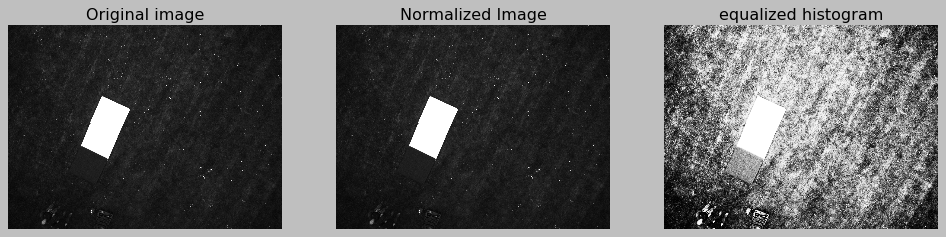

In [123]:
image_no = 1

# Load images and preserve 16-bit format
images16bit = [cv2.imread("../../../" + image_path, cv2.IMREAD_UNCHANGED) for image_path in image_paths]

# Normalize the image 
images16bit_norm = [cv2.normalize(image16bit, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) 
                   for image16bit in images16bit]

images_eq_hist = [cv2.equalizeHist(image16bit_norm) for image16bit_norm in images16bit_norm]

plt.style.use('classic')
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(images16bit[image_no], cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(images16bit_norm[image_no], cmap='gray')
ax[1].set_title('Normalized Image')
ax[1].axis('off')

ax[2].imshow(images_eq_hist[image_no], cmap='gray')
ax[2].set_title('equalized histogram')
ax[2].axis('off')

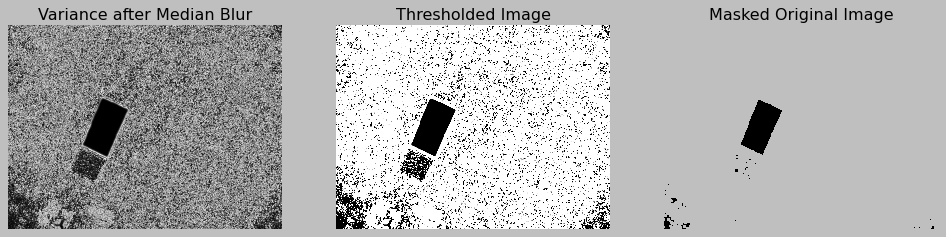

In [124]:
image = images_eq_hist[image_no]

variance = filter_by_variance(image)
blur = cv2.medianBlur(variance, 5)
ret, thresh1 = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY)
masked = np.ma.array(thresh1, mask=thresh1, fill_value=0)

plt.style.use('classic')
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(blur, cmap='gray')
ax[0].set_title('Variance after Median Blur')
ax[0].axis('off')

ax[1].imshow(thresh1, cmap='gray')
ax[1].set_title('Thresholded Image')
ax[1].axis('off')

ax[2].imshow(masked, cmap='gray')
ax[2].set_title('Masked Original Image')
ax[2].axis('off')

plt.show()

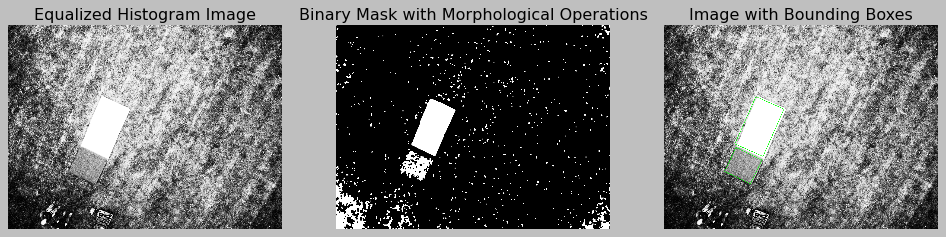

In [125]:
# Ensure masked image is correctly obtained as a binary mask
binary_mask = np.where(masked.mask, 0, 1).astype(np.uint8) * 255

# Apply morphological operations to clean up the binary mask
kernel = np.ones((5, 5), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to calculate the solidity of a contour
def contour_solidity(contour):
    area = cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    if hull_area == 0:
        return 0
    return float(area) / hull_area

# Filter contours based on size (e.g., minimum area) and solidity
min_contour_area = 14000  # Further refinement to find best minimum
min_solidity = 0.75  # currently set threshold for solidity to filter out non-homogeneous areas
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area and contour_solidity(c) > min_solidity]

# Draw rotated bounding boxes on the original image (for visualization)
image_with_bboxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored bounding boxes

# List to hold bounding box coordinates
bounding_boxes = []

for contour in filtered_contours:
    # Get the minimum area rectangle for the contour
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)  # Get the four points of the rectangle
    box = np.intp(box)  # Convert to integer values
    cv2.drawContours(image_with_bboxes, [box], 0, (0, 255, 0), 2)  # Draw the rectangle
    
    # Save the bounding box coordinates
    bounding_box = {
        "contour_index": len(bounding_boxes),  # Index of the contour
        "coordinates": box.tolist()  # Convert numpy array to list
    }
    bounding_boxes.append(bounding_box)

with open("bounding_boxes.json", "w") as f:
    json.dump(bounding_boxes, f, indent=4)

# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Equalized Histogram Image')
ax[0].axis('off')

ax[1].imshow(binary_mask, cmap='gray')
ax[1].set_title('Binary Mask with Morphological Operations')
ax[1].axis('off')

ax[2].imshow(image_with_bboxes)
ax[2].set_title('Image with Bounding Boxes')
ax[2].axis('off')

plt.show()


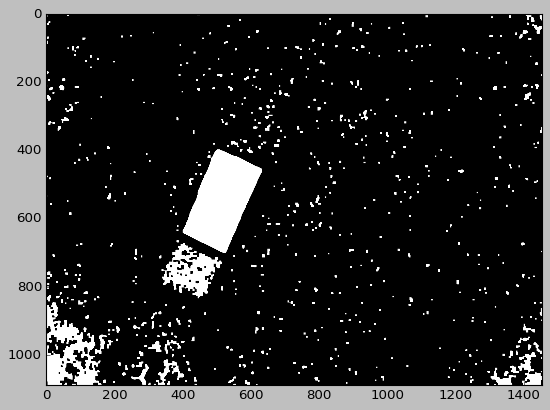

In [126]:
plt.imshow(binary_mask, cmap='gray')

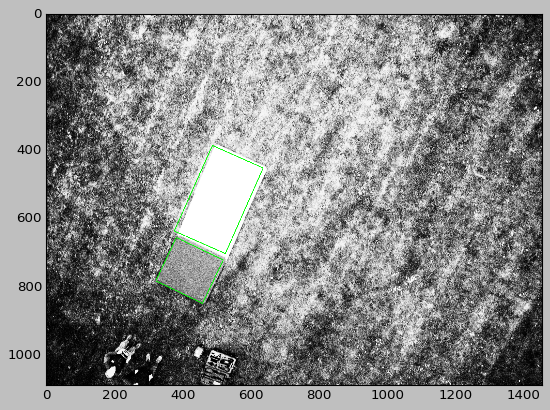

In [127]:
plt.imshow(image_with_bboxes, cmap='gray')